# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### 1) Importer le tableau de données dans un dataframe 

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [4]:
df.shape

(9582, 6)

Le dataset contient 9582 observations 

In [5]:
df.isnull().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

Le dataset contient des valeurs manquantes : 17 valeurs manquantes pour la variable "Entreprise", 19 valeurs manquantes pour la variable "Metier" et 94 valeurs manquantes pour la variable "Exprerience".

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

Regardons comment se répartissent les valeurs manquantes de la variable "Experience" selon les différents métiers

In [6]:
df[df["Experience"].isnull()==True].Metier.value_counts()

Data scientist         32
Data architecte        23
Data engineer          20
Lead data scientist    19
Name: Metier, dtype: int64

Chaque métier contient des valeurs manquantes pour la variable 'Expérience'.

In [7]:
df.Experience.describe()

count     9488
unique      21
top        1,5
freq      1023
Name: Experience, dtype: object

La variable "Expérience" est du type "object". Puisqu'il s'agit d'une variable continue, elle doit être convertie en type "float" afin de permettre le calcul de sa moyenne ou de sa médiane.
De plus, les décimales sont séparées par une virgule qui doit être remplacée par un point.

In [8]:
# Uniformisation de la variable "Experience" au type "str"
df.Experience = df.Experience.astype(str)

# Remplacement des "," par des "."
df['Experience'] = [x.replace(",",".") for x in df['Experience']]

# Conversion de la variable "Experience" au type "float"
df.Experience = df.Experience.astype(float)

Il est désormais possible d'explorer la variable "Experience" avec des indicateurs de position ou de dispersion au sein des différentes catégories de métier :

In [9]:
df.groupby('Metier').agg({'Experience':[np.median, np.mean, np.std]})

Experience                    
                        median      mean       std
Metier                                            
Data architecte            2.5  3.000476  2.723786
Data engineer              2.5  2.984959  2.778586
Data scientist             2.0  2.243282  2.527040
Lead data scientist        3.5  3.965261  2.693818

Les données manquantes de la variables "Experience" peuvent maintenant être remplacées par la médiane pour les Data scientists et par la moyenne pour les Data engineers.

In [10]:
# Data scientists

# Création d'un filtre pour un métier donné
mask_ds = (df['Metier']=='Data scientist')

# Calucul de la médiane de la variable "Experience" pour un métier donné
ds_med = df.loc[mask_ds, 'Experience'].median()

# Imputation des valeurs manquantes de la variable "Experience" pour un métier donné
df.loc[mask_ds, 'Experience'] = df.loc[mask_ds, 'Experience'].fillna(ds_med)

In [11]:
# Data engineers

# Création d'un filtre pour un métier donné
mask_de = (df['Metier']=='Data engineer') 

# Calucul de la moyenne de la variable "Experience" pour un métier donné
de_mean = round(df.loc[mask_de, 'Experience'].mean(),1)

# Imputation des valeurs manquantes de la variable "Experience" pour un métier donné
df.loc[mask_de, 'Experience'] = df.loc[mask_de, 'Experience'].fillna(de_mean)

En prévision de la question 9, les données manquantes de la variable "Experience" pour les métiers "Lead data scientist" et "Data architecte" sont également traitées.

In [12]:
# Data architectes

mask_da = (df['Metier']=='Data architecte') 
da_mean = round(df.loc[mask_da, 'Experience'].mean(),1)
df.loc[mask_da, 'Experience'] = df.loc[mask_da, 'Experience'].fillna(da_mean)

# Lead data scientists

mask_lds = (df['Metier']=='Lead data scientist') 
lds_mean = round(df.loc[mask_lds, 'Experience'].mean(),1)
df.loc[mask_lds, 'Experience'] = df.loc[mask_lds, 'Experience'].fillna(lds_mean)

In [13]:
df.isnull().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience       0
Ville            0
dtype: int64

Les 94 valeurs manquantes de la variable "Experience" ont bien été traitées.

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [14]:
# Calcul de la moyenne du nombre d'années d'expérience par métier

df.groupby('Metier').mean()

,Experience
Metier,
Data architecte,3.000471
Data engineer,2.985087
Data scientist,2.241268
Lead data scientist,3.965798


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

<Figure size 720x720 with 0 Axes>

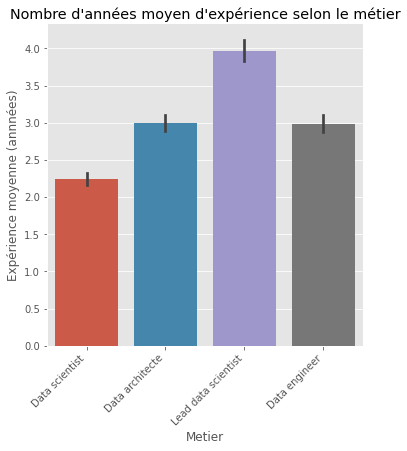

In [15]:
plt.figure( figsize= (10,10) ) 
sb.catplot(data=df,
           x='Metier',
           y='Experience',
           kind = 'bar',
          )
plt.xticks(rotation=45, ha='right')
plt.title("Nombre d'années moyen d'expérience selon le métier")
plt.ylabel("Expérience moyenne (annnées)");

Sans surprise, les Lead data scientists sont en moyenne les plus expérimentés. Les Data architectes et les Data engineers ont en moyenne 3 ans d'expérience. Les Data scientists sont les moins expérimentés avec une moyenne de 2,2 années d'expérience.

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

La variable "Experience" va être transformée en une variable catégorielle contenant 4 modalités déterminées par les quartiles. Ansi chacune des 4 modalités comportera le même nombre d'occurences.

In [16]:
df.describe()

,Experience
count,9582.000000
mean,2.814652
std,2.703889
min,0.000000
25%,1.000000
50%,2.000000
75%,3.500000
max,21.000000


In [17]:
# Création d'une nouvelle variable "Exp_label" qui comportera 4 modalités reparties selon les quartiles.

df['Exp_label']= pd.qcut(df.Experience,q=4,labels=["Débutant","Confirmé","avancé","Expert"])

# Supréssion de la variable continue "Experience"

df.drop('Experience',axis=1, inplace=True)

In [18]:
df.head()

,Entreprise,Metier,Technologies,Diplome,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,Paris,Débutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,Marseille,avancé
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,Nantes,avancé
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,Marseille,Confirmé
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,Bordeaux,Confirmé


### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

La variables "Technologies" comprend les noms des technologies maîtrisées, séparées par un "/".
Il est possible d'extraire les noms des technolologies, de les séparer et de les regrouper dans une liste unique afin de pouvoir les comptabiliser.

In [19]:
# Création d'une liste qui contiendra toutes les valeurs séparées de la variable "Technologies".

liste_tech_totale = []

# Création d'une boucle où t correspond à la variable "Technologies" pour un profil donné.

for t in df.Technologies:
    
    # Création d'une liste l contenant les noms des technologies séparées du profil t, en séparant les noms au niveau des "/".
    # les noms sont convertis en minuscules pour éviter les doublons, ex : "Scikit-learn" et "scikit-learn"
    
    l = re.split("/",t.lower())
    
    # la liste l est ajoutée à la "liste_tech_totale" en utilisant la methode extend() pour ne pas créer de sous-listes.
    
    liste_tech_totale.extend(l)

In [20]:
print("Le dataset contient",len(liste_tech_totale),"technologies.","\n")
print("Réparties en", len(np.unique(liste_tech_totale)),"valeurs uniques.","\n")
print("Qui sont :","\n"*2, np.unique(liste_tech_totale))

Le dataset contient 43712 technologies. 

Réparties en 57 valeurs uniques. 

Qui sont : 

 ['' 'ai' 'anglais' 'aws' 'big data' 'c' 'c++' 'cassandra' 'deep learning'
 'docker' 'elasticsearch' 'excel' 'gnu' 'hadoop' 'hadoop(hdfs)' 'hbase'
 'hdfs' 'hive' 'java' 'kafka' 'kibana' 'linux' 'machine learning'
 'map-reduce' 'mariadb' 'matlab' 'matplotlib' 'microsoft azure' 'mongodb'
 'mysql' 'nosq' 'nosql' 'numpy' 'oracle' 'perl' 'pig' 'postgresql'
 'pycharm' 'pyspark' 'python' 'r' 'redshift' 'ruby' 'sas' 'scala'
 'scikit-learn' 'scoring' 'spark' 'spss' 'sql' 'tableau' 'tensorflow'
 'teradata' 'vba' 'vertica' 'windows' 'yarn']


On remarque que l'une des valeur unique est vide : "", ces valeurs doivent être supprimées de la "liste_tech_totale".

In [21]:
# Création d'une boucle : soit e un élément de la 'liste_tech_totale'

for e in liste_tech_totale:
    
    # Création de la condition : l'élément de la liste comporte zero caractère
    
    if len(e)==0:
        
        # Suppression de l'élément de la liste si la condition est vérifiée.
        
        liste_tech_totale.pop(liste_tech_totale.index(e))

In [22]:
# Transforamtion de la "liste_tech_totale" en pd.Series

df_tech_total = pd.DataFrame(liste_tech_totale, columns = ["Technologies"])

In [23]:
# Création d'une liste des valeurs uniques des technologies du dataset.
# Utilisée à la question 8

tech_labels = list(pd.unique(df_tech_total.Technologies))

Il est désomais possible de compter le nombre d'occurences de chaque technologie et de les classer :

In [24]:
df_tech_total.value_counts().sort_values(ascending=False).head()

Technologies
python          6627
r               4374
sql             2581
java            1719
hadoop          1589
dtype: int64

Pyton, R, SQL, Java et hadoop sont les technologies les plus utilisées.

C:\Users\peyre\anaconda3\envs\appli\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


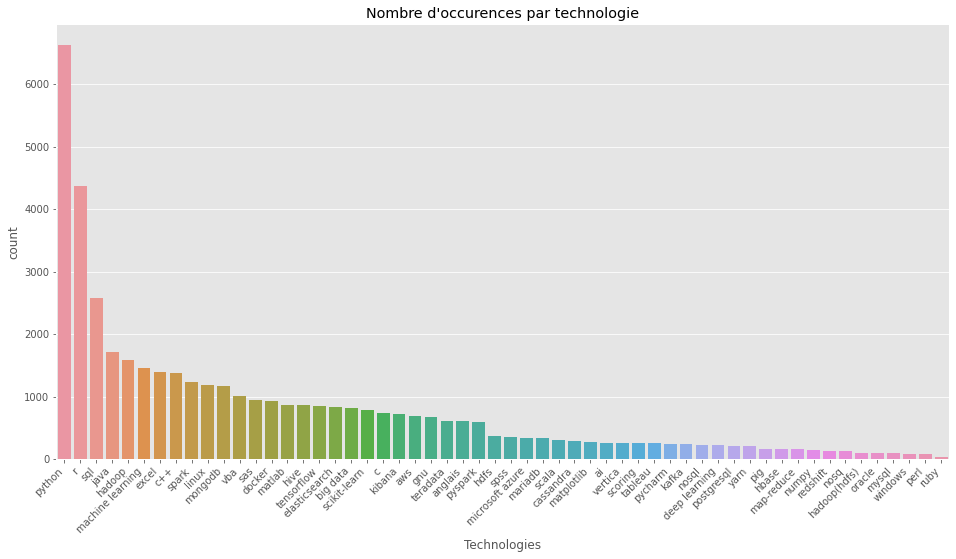

In [25]:
plt.figure( figsize= (16, 8)) 
sb.countplot(df_tech_total.Technologies,
            order = df_tech_total.Technologies.value_counts().index)
plt.title("Nombre d'occurences par technologie")
plt.xticks(rotation=45,ha='right');

L'observation graphique du nombre d'occurences par technologie nous permet bien d'identifier Python, R, SQL, Java et Hadoop comme les technologies les plus utilisées.

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

Afin de repartir les profils techniques en deux clusters nous allons devoir créer une matrice où chaque colonne correspond à une technologie et chaque ligne correspond à un profil, avec pour valeur 1 si la technologie est maîtrisée ou 0 sinon.

In [26]:
# Création d'une liste contenant une sous-liste de technologies par profil.


# Création de la liste
liste_tech =[]

# On répete la methode utilisée à la question 7 en utilisant cette fois append() pour créer une sous-liste par profil.

for x in df.Technologies:
    l = re.split("/",x.lower())
    liste_tech.append(l)

In [27]:
# Création d'une matrice remplie de zéros comportant un nombre de colonnes égal au nombre de technologies (valeurs uniques) et 
# un nombre de lignes égal au nombre de profils.

tech_array = np.zeros((len(liste_tech),len(tech_labels)))

# x correspond à l'index de la ligne de la matrice
x = -1

# création d'une boucle où i correspond à une sous-liste de la "liste_tech"

for i in liste_tech:
    
    # Mise à jour de l'index de la ligne de ma matrice
    x +=1
    
    # Réinitialisation de l'index de la colonne de la matrice
    y = -1
    
    # Création d'une boucle dans la boucle, où t est une technologie de la liste des valeurs uniques des technologie.
    
    for t in tech_labels:
        
        # Mise à jour de l'index de la colonne de la matrice
        
        y+=1
        
        # Création de la condition : la technologie t est présente dans la sous-liste i 
        
        if t in i:
            
            # Modification de la valeur dans la matrice si la condition est vérifée.
            
            tech_array[x,y]=1
            
print(tech_array.shape)

(9582, 56)


In [28]:
# Transformation de la matrice en Dataframe et ajout des labels des colonnes (noms des technologies)

df_tech = pd.DataFrame(data=tech_array,columns=tech_labels)

In [29]:
print(df_tech.shape)
df_tech.head()

(9582, 56)


,matlab,python,pyspark,scikit-learn,tensorflow,java,scala,mongodb,spss,sql,...,mysql,cassandra,nosql,matplotlib,map-reduce,pig,hbase,windows,nosq,hadoop(hdfs)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Une autre alternative pour obtenir la même matrice plus rapidement aurait été d'utiliser l'algorithme CountVectorizer sur la colonne "Technologies" du df de départ en prennant soin de bien paramétrer le paramètre 'token_pattern' de manière à couper uniquement sur les '/' tout en conservant les traits d'union, les espaces, les parenthèses et les "+" :

In [30]:
# Solution alternative

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern = r"[a-z-\(\)\+ ]+")
m = vectorizer.fit_transform(df.Technologies).todense()

df_tech2 = pd.DataFrame(data=m, columns = vectorizer.get_feature_names())
print(df_tech2.shape)

(9582, 56)


Nous pouvons maintenant utiliser un algorithme de clustering non supervisé tel que KMeans pour faire apparaitre deux clusters

In [31]:
from sklearn.cluster import KMeans

# Création d'un modèle KMeans à 2 clusters
clf = KMeans(n_clusters = 2)

# Entrainement du modèle à partir du df_tech
clf.fit(df_tech)

# Création de la liste des labels calculés
labels = clf.labels_ 

In [32]:
# Ajout d'une nouvelle variable "Cluster" au df.

df['Cluster']=labels

Le coefficient de Silhouette permet d'évaluer la performance d'un clutering. Il est compris entre -1 et 1.

In [33]:
from sklearn.metrics import silhouette_score

s_score = silhouette_score(df_tech, labels, metric='sqeuclidean')
print(s_score)

0.2386483980009762


Le score obtenu est d'environ 0.24 ce qui montre que nos clusters sont pertinants bien qu'imparfaits.

C:\Users\peyre\anaconda3\envs\appli\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\peyre\anaconda3\envs\appli\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


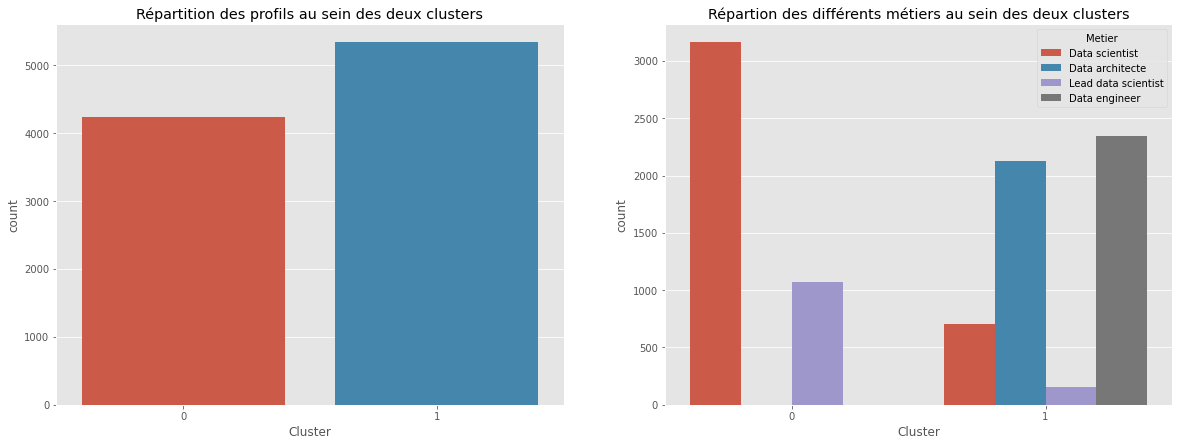

In [34]:
plt.figure( figsize= (20, 7)) 
plt.subplot(1,2,1)
sb.countplot(df.Cluster)
plt.title("Répartition des profils au sein des deux clusters")
plt.subplot(1,2,2)
sb.countplot(df.Cluster, hue = df.Metier)
plt.title("Répartion des différents métiers au sein des deux clusters");

Le cluster 1 comprend uniquement des Data scientists et des Lead Data scientists.
Le cluster 0 comprend l'ensemble des Data engineers et des Data architectes ainsi qu'une petite proportion de Data scientists et de Lead data scientists.
Ces résultats sont conformes à nos attentes et montrent que les Data scientists et les Lead data scientists maitrisent les mêmes technologies.
Toutefois certains profils de Data scientists et de Lead data scientists, probablement très polyvalants, ont été regroupés avec les Data engineers et les Data architectes.

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

Tout d'abord, interessons nous à la répartition des métiers au sein du dataset :

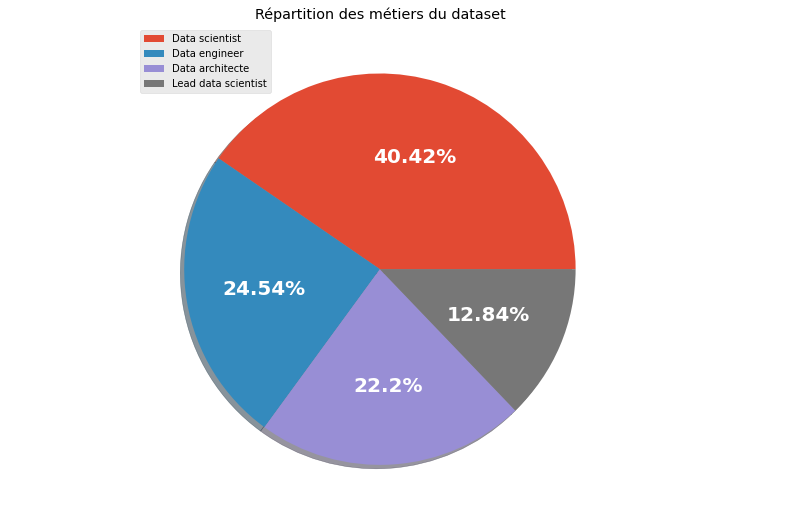

In [35]:
plt.figure(figsize =(9,9))
plt.pie(df.Metier.value_counts(),
       shadow = True, 
       autopct = lambda x: str(round(x,2))+"%", pctdistance = 0.6, 
       labels = df.Metier.value_counts().index,
       textprops = {'color':'w','size':20,'weight':'bold'})
plt.legend(loc = 2,fontsize = 10)
plt.title('Répartition des métiers du dataset');

Les data scientists sont sur-représentés tandis que les Lead data scientists sont sous-représentés.
Le dataset est donc plutôt deséquilibré.

Doit-on conserver les variables "Entreprise", "Diplome" et "Ville" ?

In [36]:
df[['Entreprise','Diplome','Ville']].describe()

,Entreprise,Diplome,Ville
count,9565,9582,9582
unique,1382,4,14
top,Ball Aerospace,Master,Paris
freq,748,4971,2015


La variable "Diplome" comporte 4 valeurs uniques ce qui la rend propice à la dichotomisation.
En revanche la variable "Entreprise" comporte beaucoup trop de valeurs uniques, je décide donc de m'en dispenser.
La variable "Ville" à un nombre raisonnable de valeurs uniques, je décide de la conserver.

In [37]:
# Création d'un nouveau dataframe regroupant le df de départ et le df_tech utilisé pour le clustering

df_total = df.join(df_tech)

#Suppression des colonnes "Technologies" et "Entreprise"

df_total.drop((['Technologies','Entreprise']),axis=1,inplace=True)

# Dichotomisation des variables "Ville", "Exp_label" et "Diplome"

df_total = pd.get_dummies(df_total, columns = ['Ville','Exp_label','Diplome'])



In [38]:
# Création d'un dataframe df_pred comportant les profils non labélisés

df_pred = df_total[df_total['Metier'].isnull()== True]

# Suppression de la colonne "Metier" non labelisée

df_pred.drop('Metier',axis=1, inplace=True)

C:\Users\peyre\anaconda3\envs\appli\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [39]:
# Suppression des profils non labélisés du df_total (les 19 dernières valeurs manquantes sont toutes des métiers)

df_total = df_total.dropna()

# Séparation des features et de la target

data = df_total.drop('Metier',axis=1)
target = df_total.Metier

In [40]:
# Création des ensembles d'entrainement et de test.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.2, random_state=10)

In [41]:
# Comparaison de trois modèles de classification (Regression Logistique, SVM et Random Forest) par cross-validation


from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#création des modeles

clf_lr  = LogisticRegression(max_iter=2000)
clf_rf  = RandomForestClassifier()
clf_svc = SVC()

# Création de sous-ensembles

CV = StratifiedKFold(n_splits=3, shuffle=True, random_state = 10)

# Création d'une boucle incluant les 3 modèles

for clf in [clf_lr, clf_rf, clf_svc]:
    
    # Calcul des scores obtenus par cross-validation (un score par sous-ensemble)
    
    cv_score = cross_val_score(clf, X_train, y_train, cv = CV)
    
    # Calcul de la moyenne et de l'écart-type des score de chaque modèle
    
    print(clf,':',round(cv_score.mean(),3), "+/-",round(cv_score.std(),3))

LogisticRegression(max_iter=2000) : 0.893 +/- 0.003
RandomForestClassifier() : 0.88 +/- 0.005
SVC() : 0.892 +/- 0.006


Les performances des trois modèles sont très proches. Je decide de poursuivre avec la regression logistique.

In [42]:
# Création d'un dictionnaire d'hyperparametres

param_grid_lr  = {'solver': ['liblinear', 'lbfgs'],
                   'C': np.logspace(-4,2,9),
                 'class_weight' :['balanced',None] }



from sklearn.model_selection import GridSearchCV

# Création d'un modèle GridSearchCV pour identifier la meilleure combinaison d'hyperparamètres

grid_clf = GridSearchCV(clf_lr, param_grid_lr, cv=3, refit =True)

# Entrainement de la grille d'hyperparmètres

grille = grid_clf.fit(X_train, y_train) 

# Selection des meilleurs hyperparamètres

print("Les meilleurs hyperparamètres sont : \n",grid_clf.best_params_)

# Prédiction des labels de l'ensemble de test

y_pred = grid_clf.predict(X_test)

Les meilleurs hyperparamètres sont : 
 {'C': 3.1622776601683795, 'class_weight': None, 'solver': 'lbfgs'}


In [43]:
from sklearn.metrics import classification_report

# Calcul de l'accuracy

score = grid_clf.score(X_test,y_test)
print("accuracy =", round(score,4),"\n")

# Calculs du score de rappel et du F1-score

print(classification_report(y_test,y_pred),"\n")

# Création d'une matrice de confusion

pd.crosstab(y_test,y_pred, rownames=['Labels'], colnames = ['Predictions'])

accuracy = 0.8902 

                     precision    recall  f1-score   support

    Data architecte       0.97      0.98      0.97       389
      Data engineer       1.00      1.00      1.00       477
     Data scientist       0.84      0.92      0.88       790
Lead data scientist       0.68      0.47      0.55       257

           accuracy                           0.89      1913
          macro avg       0.87      0.84      0.85      1913
       weighted avg       0.88      0.89      0.88      1913
 



Predictions,Data architecte,Data engineer,Data scientist,Lead data scientist
Labels,,,,
Data architecte,380,0,9,0
Data engineer,0,477,0,0
Data scientist,8,0,726,56
Lead data scientist,4,0,133,120


Ce modèle de Regression Logistique permet d'identifier parfaitement les profils de Data engineers comme le montre la matrice de confusion et son f1-score de 1.
Les Data architectes sont plutôt bien reconnus également. La principale source d'erreur se situe entre les Data scientists et les Lead data scientists. En effet, à en voir son score de rappel, plus de la moitié des Lead Data scientists n'ont pas été reconnus en tant que tels.
Ceci est explicable d'une part car ce sont les métiers les plus proches au niveau des compétences technologiques, d'autre part, la sous-représentation des Lead data scientists
dans le dataset tend à faire diminuer les performances. 
Il aurait été intéressant de proceder à un rééchantillonnage grace au outils proposés par la librairie imblearn par exemple.

In [44]:
# Prédictions des métiers non labelisés

finales_pred = grid_clf.predict(df_pred)

# Création d'un DataFrame de résultats

df_predictions  = df[df['Metier'].isnull()==True]
df_predictions['Prediction_Metier']= finales_pred
df_predictions.drop('Metier',axis=1, inplace= True)
df_predictions.head(19)

<ipython-input-44-7eabc3733ab9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predictions['Prediction_Metier']= finales_pred
C:\Users\peyre\anaconda3\envs\appli\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Entreprise,Technologies,Diplome,Ville,Exp_label,Cluster,Prediction_Metier
346,Jacobs,Python/Spark/GNU/Linux,No diploma,Paris,avancé,1,Data engineer
2058,Ball Aerospace,VBA/Python/Excel/R,Master,Lyon,Expert,0,Lead data scientist
2670,"eHire, LLC",Java/C/C++/R/Python,Master,Toulouse,Confirmé,1,Data scientist
2899,Norfolk Southern Corp,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,Grenoble,Débutant,0,Data scientist
3346,J.E. Ranta Associates,Cassandra/MongoDB/NoSQL/AWS,Master,Rennes,Expert,1,Data architecte
4248,KPMG,Python/Microsoft Azure/R/SQL,Phd,Lyon,Confirmé,0,Data scientist
4290,"Pandora Media, Inc.",SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Phd,Toulouse,Confirmé,0,Data scientist
4292,Partners HealthCare(PHS),SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,Bordeaux,Expert,0,Lead data scientist
5425,Ashton Lane Group,Python/Pyspark/Spark,No diploma,Lyon,Expert,1,Data engineer
5593,Lighthouse Lab Services,Python/R/machine learning/Excel/VBA/C++,Master,Lyon,avancé,0,Data scientist
